Bu kodlar, Keras ve TensorFlow kullanarak Fashion MNIST veri kümesinde bir Generative Adversarial Network (GAN) eğitmek ve değerlendirmek için yazılmış bir örneği anlatmaktadır.

In [ ]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

1.Veri Yükleme ve Ön İşleme

In [ ]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


 - Fashion MNIST veri kümesi yüklenir ve normalize edilir (-1 ile 1 arasında).
 - Giriş verisi (X_train) 4 boyutlu bir tensöre dönüştürülür (`(60000, 28, 28, 1)`)

2. **Yardımcı Fonksiyonlar**:
   - **Latent Noktaları Üretme**: Rastgele gürültü vektörleri üretir.
   - **Gerçek Örnekler Üretme**: Eğitim veri setinden rastgele örnekler seçer.
   - **Sahte Örnekler Üretme**: Generator modelini kullanarak sahte örnekler üretir.
   - **Performans Özetleme**: Eğitim sırasında belirli aralıklarla sahte örnekler üreterek ve modeli kaydederek performansı özetler.
   - **Görseli Kaydetme**: Üretilen örneklerin görüntülerini kaydeder ve gösterir.


In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input


In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y


In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y


In [ ]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))


In [ ]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()


 3. **Discriminator Tanımlama**:

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [ ]:
discriminator = define_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 - Discriminator modeli, gerçek ve sahte görüntüleri ayırt etmek için bir evrişimsel sinir ağıdır. Model, giriş olarak 28x28 tek kanallı (gri tonlamalı) görüntüler alır ve bir olasılık değeri (0 veya 1) döndürür.



4. **Generator Tanımlama**:


In [ ]:
def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model


In [ ]:
generator = define_generator(100)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 - Generator modeli, rastgele gürültü vektörlerini alır ve 28x28 tek kanallı sahte görüntüler üretir.

5. **GAN Tanımlama**:


In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [ ]:
gan_model = define_gan(generator, discriminator)

 - GAN modeli, generator ve discriminator modellerini birleştirir. Discriminator eğitilebilirliği kapalıdır, böylece sadece generator eğitilir.


6. **Eğitim Fonksiyonu**:


In [ ]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)


- GAN modelini eğitir. Eğitimin her adımında, gerçek ve sahte örneklerle discriminator eğitilir, ardından generator eğitilir.



7. **Model Eğitimi ve Değerlendirme**:

- Model 20 epoch boyunca eğitilir. Her epoch sonunda performans özetlenir.

2/2 [==============================] - 1s 19ms/step
>1, dr[0.765,0.484], df[0.696,0.250], g[0.691,0.766]
2/2 [==============================] - 0s 30ms/step
>2, dr[0.116,1.000], df[0.708,0.000], g[0.681,0.984]
2/2 [==============================] - 0s 20ms/step
>3, dr[0.040,1.000], df[0.720,0.000], g[0.670,1.000]
2/2 [==============================] - 0s 13ms/step
>4, dr[0.024,1.000], df[0.734,0.000], g[0.656,1.000]
2/2 [==============================] - 0s 27ms/step
>5, dr[0.016,1.000], df[0.756,0.000], g[0.639,1.000]
2/2 [==============================] - 0s 19ms/step
>6, dr[0.013,1.000], df[0.789,0.000], g[0.623,1.000]
2/2 [==============================] - 0s 20ms/step
>7, dr[0.019,1.000], df[0.809,0.000], g[0.605,1.000]
2/2 [==============================] - 0s 28ms/step
>8, dr[0.009,1.000], df[0.849,0.000], g[0.590,1.000]
2/2 [==============================] - 0s 16ms/step
>9, dr[0.008,1.000], df[0.867,0.000], g[0.585,1.000]
2/2 [==============================] - 0s 15ms/step
>10

>Saved: model_0937.h5
2/2 [==============================] - 0s 11ms/step
>938, dr[0.346,0.875], df[0.302,0.875], g[3.094,0.000]
2/2 [==============================] - 0s 11ms/step
>939, dr[0.309,0.812], df[0.378,0.766], g[3.362,0.016]
2/2 [==============================] - 0s 13ms/step
>940, dr[0.360,0.828], df[0.239,0.906], g[2.945,0.000]
2/2 [==============================] - 0s 11ms/step
>941, dr[0.133,0.938], df[0.183,0.969], g[3.368,0.000]
2/2 [==============================] - 0s 10ms/step
>942, dr[0.479,0.828], df[0.583,0.797], g[3.578,0.000]
2/2 [==============================] - 0s 10ms/step
>943, dr[0.391,0.812], df[0.159,0.953], g[3.047,0.000]
2/2 [==============================] - 0s 11ms/step
>944, dr[0.427,0.734], df[0.289,0.938], g[2.255,0.000]
2/2 [==============================] - 0s 11ms/step
>945, dr[0.253,0.906], df[0.401,0.844], g[2.987,0.000]
2/2 [==============================] - 0s 11ms/step
>946, dr[0.255,0.891], df[0.202,0.969], g[3.316,0.000]
2/2 [==========

>Saved: model_1874.h5
2/2 [==============================] - 0s 20ms/step
>1875, dr[0.797,0.562], df[0.554,0.797], g[2.903,0.016]
2/2 [==============================] - 0s 11ms/step
>1876, dr[0.674,0.641], df[0.474,0.828], g[2.528,0.047]
2/2 [==============================] - 0s 17ms/step
>1877, dr[0.588,0.672], df[0.432,0.859], g[1.918,0.094]
2/2 [==============================] - 0s 21ms/step
>1878, dr[0.539,0.734], df[0.493,0.797], g[1.932,0.047]
2/2 [==============================] - 0s 21ms/step
>1879, dr[0.710,0.562], df[0.587,0.750], g[1.700,0.031]
2/2 [==============================] - 0s 16ms/step
>1880, dr[0.413,0.766], df[0.481,0.812], g[2.177,0.094]
2/2 [==============================] - 0s 13ms/step
>1881, dr[0.546,0.656], df[0.457,0.812], g[1.956,0.078]
2/2 [==============================] - 0s 17ms/step
>1882, dr[0.559,0.719], df[0.451,0.875], g[2.112,0.031]
2/2 [==============================] - 0s 10ms/step
>1883, dr[0.384,0.797], df[0.396,0.859], g[2.053,0.094]
2/2 [=

>Saved: model_2811.h5
2/2 [==============================] - 0s 12ms/step
>2812, dr[0.408,0.812], df[0.492,0.828], g[1.750,0.047]
2/2 [==============================] - 0s 11ms/step
>2813, dr[0.429,0.688], df[0.408,0.875], g[1.771,0.016]
2/2 [==============================] - 0s 13ms/step
>2814, dr[0.332,0.797], df[0.284,0.984], g[1.913,0.000]
2/2 [==============================] - 0s 12ms/step
>2815, dr[0.312,0.812], df[0.284,0.969], g[1.824,0.047]
2/2 [==============================] - 0s 12ms/step
>2816, dr[0.328,0.812], df[0.365,0.906], g[1.956,0.047]
2/2 [==============================] - 0s 13ms/step
>2817, dr[0.555,0.641], df[0.328,0.922], g[1.579,0.125]
2/2 [==============================] - 0s 12ms/step
>2818, dr[0.372,0.797], df[0.538,0.750], g[1.742,0.031]
2/2 [==============================] - 0s 12ms/step
>2819, dr[0.474,0.703], df[0.366,0.906], g[1.762,0.047]
2/2 [==============================] - 0s 12ms/step
>2820, dr[0.534,0.641], df[0.428,0.875], g[1.898,0.047]
2/2 [=

>Saved: model_3748.h5
2/2 [==============================] - 0s 15ms/step
>3749, dr[0.595,0.672], df[0.405,0.844], g[1.705,0.078]
2/2 [==============================] - 0s 12ms/step
>3750, dr[0.544,0.641], df[0.507,0.859], g[1.750,0.062]
2/2 [==============================] - 0s 43ms/step
>3751, dr[0.662,0.625], df[0.468,0.906], g[1.458,0.125]
2/2 [==============================] - 0s 18ms/step
>3752, dr[0.480,0.750], df[0.473,0.844], g[1.467,0.062]
2/2 [==============================] - 0s 22ms/step
>3753, dr[0.485,0.656], df[0.424,0.812], g[1.658,0.031]
2/2 [==============================] - 0s 24ms/step
>3754, dr[0.581,0.688], df[0.504,0.828], g[1.710,0.094]
2/2 [==============================] - 0s 28ms/step
>3755, dr[0.479,0.688], df[0.455,0.859], g[1.542,0.094]
2/2 [==============================] - 0s 34ms/step
>3756, dr[0.499,0.734], df[0.533,0.812], g[1.617,0.031]
2/2 [==============================] - 0s 19ms/step
>3757, dr[0.556,0.625], df[0.321,0.953], g[1.586,0.047]
2/2 [=

>Saved: model_4685.h5
2/2 [==============================] - 0s 11ms/step
>4686, dr[0.667,0.547], df[0.481,0.891], g[1.247,0.125]
2/2 [==============================] - 0s 17ms/step
>4687, dr[0.555,0.609], df[0.505,0.859], g[1.194,0.156]
2/2 [==============================] - 0s 12ms/step
>4688, dr[0.590,0.625], df[0.616,0.719], g[1.246,0.094]
2/2 [==============================] - 0s 11ms/step
>4689, dr[0.614,0.609], df[0.512,0.828], g[1.163,0.156]
2/2 [==============================] - 0s 12ms/step
>4690, dr[0.631,0.562], df[0.516,0.781], g[1.351,0.078]
2/2 [==============================] - 0s 13ms/step
>4691, dr[0.545,0.609], df[0.521,0.812], g[1.246,0.156]
2/2 [==============================] - 0s 11ms/step
>4692, dr[0.762,0.469], df[0.518,0.844], g[1.143,0.141]
2/2 [==============================] - 0s 12ms/step
>4693, dr[0.642,0.609], df[0.612,0.781], g[1.100,0.172]
2/2 [==============================] - 0s 12ms/step
>4694, dr[0.615,0.547], df[0.575,0.766], g[1.208,0.141]
2/2 [=

>Saved: model_5622.h5
2/2 [==============================] - 0s 25ms/step
>5623, dr[0.586,0.641], df[0.559,0.797], g[1.325,0.047]
2/2 [==============================] - 0s 15ms/step
>5624, dr[0.508,0.672], df[0.458,0.844], g[1.292,0.094]
2/2 [==============================] - 0s 16ms/step
>5625, dr[0.654,0.531], df[0.540,0.797], g[1.265,0.094]
2/2 [==============================] - 0s 12ms/step
>5626, dr[0.574,0.625], df[0.580,0.734], g[1.167,0.188]
2/2 [==============================] - 0s 14ms/step
>5627, dr[0.742,0.531], df[0.733,0.688], g[1.194,0.109]
2/2 [==============================] - 0s 13ms/step
>5628, dr[0.635,0.594], df[0.455,0.844], g[1.179,0.156]
2/2 [==============================] - 0s 14ms/step
>5629, dr[0.614,0.672], df[0.577,0.812], g[1.124,0.203]
2/2 [==============================] - 0s 13ms/step
>5630, dr[0.510,0.672], df[0.482,0.828], g[1.257,0.047]
2/2 [==============================] - 0s 11ms/step
>5631, dr[0.639,0.578], df[0.453,0.891], g[1.000,0.250]
2/2 [=

>Saved: model_6559.h5
2/2 [==============================] - 0s 12ms/step
>6560, dr[0.538,0.641], df[0.612,0.766], g[1.155,0.094]
2/2 [==============================] - 0s 11ms/step
>6561, dr[0.594,0.562], df[0.548,0.797], g[1.276,0.078]
2/2 [==============================] - 0s 12ms/step
>6562, dr[0.732,0.422], df[0.480,0.828], g[1.195,0.031]
2/2 [==============================] - 0s 14ms/step
>6563, dr[0.667,0.531], df[0.534,0.797], g[1.139,0.203]
2/2 [==============================] - 0s 15ms/step
>6564, dr[0.603,0.609], df[0.556,0.719], g[1.170,0.109]
2/2 [==============================] - 0s 13ms/step
>6565, dr[0.649,0.562], df[0.490,0.875], g[1.174,0.078]
2/2 [==============================] - 0s 13ms/step
>6566, dr[0.479,0.688], df[0.565,0.797], g[1.174,0.125]
2/2 [==============================] - 0s 14ms/step
>6567, dr[0.551,0.656], df[0.607,0.672], g[1.196,0.125]
2/2 [==============================] - 0s 13ms/step
>6568, dr[0.704,0.547], df[0.547,0.781], g[1.135,0.156]
2/2 [=

>Saved: model_7496.h5
2/2 [==============================] - 0s 20ms/step
>7497, dr[0.724,0.453], df[0.627,0.766], g[1.124,0.141]
2/2 [==============================] - 0s 23ms/step
>7498, dr[0.531,0.656], df[0.543,0.797], g[1.182,0.125]
2/2 [==============================] - 0s 18ms/step
>7499, dr[0.581,0.641], df[0.576,0.719], g[1.118,0.188]
2/2 [==============================] - 0s 19ms/step
>7500, dr[0.713,0.531], df[0.676,0.750], g[1.062,0.141]
2/2 [==============================] - 0s 18ms/step
>7501, dr[0.662,0.562], df[0.574,0.719], g[1.071,0.172]
2/2 [==============================] - 0s 16ms/step
>7502, dr[0.528,0.656], df[0.640,0.641], g[1.116,0.188]
2/2 [==============================] - 0s 11ms/step
>7503, dr[0.520,0.734], df[0.508,0.812], g[1.184,0.141]
2/2 [==============================] - 0s 14ms/step
>7504, dr[0.744,0.484], df[0.533,0.797], g[1.072,0.172]
2/2 [==============================] - 0s 13ms/step
>7505, dr[0.713,0.484], df[0.491,0.812], g[1.074,0.188]
2/2 [=

>Saved: model_8433.h5
2/2 [==============================] - 0s 18ms/step
>8434, dr[0.640,0.562], df[0.632,0.734], g[1.083,0.203]
2/2 [==============================] - 0s 13ms/step
>8435, dr[0.592,0.609], df[0.589,0.750], g[1.110,0.125]
2/2 [==============================] - 0s 11ms/step
>8436, dr[0.538,0.656], df[0.601,0.750], g[1.119,0.094]
2/2 [==============================] - 0s 13ms/step
>8437, dr[0.694,0.453], df[0.594,0.750], g[1.011,0.250]
2/2 [==============================] - 0s 13ms/step
>8438, dr[0.663,0.531], df[0.536,0.812], g[1.055,0.156]
2/2 [==============================] - 0s 12ms/step
>8439, dr[0.658,0.500], df[0.537,0.797], g[1.054,0.141]
2/2 [==============================] - 0s 13ms/step
>8440, dr[0.544,0.625], df[0.576,0.781], g[1.025,0.219]
2/2 [==============================] - 0s 11ms/step
>8441, dr[0.563,0.578], df[0.726,0.688], g[1.185,0.062]
2/2 [==============================] - 0s 11ms/step
>8442, dr[0.690,0.422], df[0.537,0.734], g[1.085,0.172]
2/2 [=

>Saved: model_9370.h5
2/2 [==============================] - 0s 13ms/step
>9371, dr[0.645,0.562], df[0.535,0.812], g[0.964,0.188]
2/2 [==============================] - 0s 11ms/step
>9372, dr[0.580,0.531], df[0.533,0.812], g[1.003,0.156]
2/2 [==============================] - 0s 12ms/step
>9373, dr[0.664,0.500], df[0.647,0.672], g[1.036,0.188]
2/2 [==============================] - 0s 18ms/step
>9374, dr[0.606,0.609], df[0.653,0.719], g[1.093,0.062]
2/2 [==============================] - 0s 12ms/step
>9375, dr[0.612,0.578], df[0.527,0.844], g[1.059,0.125]
2/2 [==============================] - 0s 13ms/step
>9376, dr[0.584,0.578], df[0.601,0.734], g[1.080,0.109]
2/2 [==============================] - 0s 11ms/step
>9377, dr[0.591,0.547], df[0.638,0.750], g[1.089,0.062]
2/2 [==============================] - 0s 11ms/step
>9378, dr[0.578,0.625], df[0.543,0.797], g[1.054,0.078]
2/2 [==============================] - 0s 19ms/step
>9379, dr[0.603,0.578], df[0.550,0.859], g[1.032,0.125]
2/2 [=

>Saved: model_10307.h5
2/2 [==============================] - 0s 14ms/step
>10308, dr[0.564,0.641], df[0.520,0.750], g[0.959,0.234]
2/2 [==============================] - 0s 21ms/step
>10309, dr[0.636,0.531], df[0.714,0.719], g[1.027,0.203]
2/2 [==============================] - 0s 13ms/step
>10310, dr[0.585,0.641], df[0.579,0.797], g[0.941,0.312]
2/2 [==============================] - 0s 14ms/step
>10311, dr[0.579,0.641], df[0.631,0.625], g[0.972,0.250]
2/2 [==============================] - 0s 16ms/step
>10312, dr[0.591,0.625], df[0.691,0.594], g[0.885,0.297]
2/2 [==============================] - 0s 15ms/step
>10313, dr[0.653,0.547], df[0.697,0.688], g[0.918,0.234]
2/2 [==============================] - 0s 23ms/step
>10314, dr[0.641,0.609], df[0.635,0.719], g[0.994,0.234]
2/2 [==============================] - 0s 12ms/step
>10315, dr[0.649,0.562], df[0.724,0.656], g[1.037,0.156]
2/2 [==============================] - 0s 16ms/step
>10316, dr[0.670,0.547], df[0.611,0.797], g[0.968,0.1

>Saved: model_11244.h5
2/2 [==============================] - 0s 14ms/step
>11245, dr[0.536,0.672], df[0.613,0.703], g[1.020,0.188]
2/2 [==============================] - 0s 15ms/step
>11246, dr[0.603,0.562], df[0.611,0.734], g[0.999,0.203]
2/2 [==============================] - 0s 14ms/step
>11247, dr[0.647,0.562], df[0.545,0.797], g[1.067,0.141]
2/2 [==============================] - 0s 12ms/step
>11248, dr[0.682,0.531], df[0.637,0.734], g[1.030,0.094]
2/2 [==============================] - 0s 15ms/step
>11249, dr[0.622,0.625], df[0.621,0.688], g[1.048,0.109]
2/2 [==============================] - 0s 11ms/step
>11250, dr[0.687,0.531], df[0.670,0.719], g[0.969,0.109]
2/2 [==============================] - 0s 14ms/step
>11251, dr[0.737,0.422], df[0.609,0.734], g[1.107,0.156]
2/2 [==============================] - 0s 13ms/step
>11252, dr[0.632,0.625], df[0.562,0.797], g[1.051,0.219]
2/2 [==============================] - 0s 13ms/step
>11253, dr[0.666,0.562], df[0.679,0.609], g[1.123,0.0

>Saved: model_12181.h5
2/2 [==============================] - 0s 17ms/step
>12182, dr[0.638,0.562], df[0.498,0.859], g[0.995,0.219]
2/2 [==============================] - 0s 22ms/step
>12183, dr[0.620,0.562], df[0.757,0.688], g[1.022,0.141]
2/2 [==============================] - 0s 10ms/step
>12184, dr[0.690,0.562], df[0.551,0.766], g[0.978,0.203]
2/2 [==============================] - 0s 19ms/step
>12185, dr[0.717,0.500], df[0.594,0.703], g[0.969,0.188]
2/2 [==============================] - 0s 16ms/step
>12186, dr[0.636,0.594], df[0.647,0.703], g[1.029,0.188]
2/2 [==============================] - 0s 21ms/step
>12187, dr[0.635,0.516], df[0.610,0.781], g[1.011,0.172]
2/2 [==============================] - 0s 15ms/step
>12188, dr[0.596,0.578], df[0.643,0.734], g[0.975,0.156]
2/2 [==============================] - 0s 12ms/step
>12189, dr[0.636,0.578], df[0.599,0.750], g[0.982,0.156]
2/2 [==============================] - 0s 16ms/step
>12190, dr[0.647,0.531], df[0.578,0.688], g[0.982,0.1

>Saved: model_13118.h5
2/2 [==============================] - 0s 12ms/step
>13119, dr[0.662,0.531], df[0.605,0.734], g[1.016,0.125]
2/2 [==============================] - 0s 26ms/step
>13120, dr[0.682,0.438], df[0.567,0.734], g[0.980,0.172]
2/2 [==============================] - 0s 22ms/step
>13121, dr[0.664,0.547], df[0.596,0.750], g[1.001,0.172]
2/2 [==============================] - 0s 22ms/step
>13122, dr[0.631,0.531], df[0.638,0.688], g[0.992,0.172]
2/2 [==============================] - 0s 16ms/step
>13123, dr[0.623,0.594], df[0.553,0.875], g[0.979,0.188]
2/2 [==============================] - 0s 20ms/step
>13124, dr[0.709,0.453], df[0.622,0.656], g[0.930,0.203]
2/2 [==============================] - 0s 18ms/step
>13125, dr[0.562,0.641], df[0.736,0.594], g[0.952,0.219]
2/2 [==============================] - 0s 21ms/step
>13126, dr[0.643,0.516], df[0.570,0.750], g[1.004,0.109]
2/2 [==============================] - 0s 14ms/step
>13127, dr[0.644,0.516], df[0.591,0.797], g[1.074,0.1

>Saved: model_14055.h5
2/2 [==============================] - 0s 13ms/step
>14056, dr[0.574,0.609], df[0.560,0.766], g[0.955,0.219]
2/2 [==============================] - 0s 16ms/step
>14057, dr[0.653,0.609], df[0.629,0.688], g[0.907,0.219]
2/2 [==============================] - 0s 15ms/step
>14058, dr[0.561,0.672], df[0.681,0.609], g[0.873,0.359]
2/2 [==============================] - 0s 24ms/step
>14059, dr[0.590,0.641], df[0.547,0.812], g[0.978,0.219]
2/2 [==============================] - 0s 22ms/step
>14060, dr[0.575,0.656], df[0.634,0.656], g[1.022,0.172]
2/2 [==============================] - 0s 12ms/step
>14061, dr[0.591,0.672], df[0.595,0.719], g[0.927,0.297]
2/2 [==============================] - 0s 16ms/step
>14062, dr[0.594,0.594], df[0.600,0.672], g[1.091,0.125]
2/2 [==============================] - 0s 12ms/step
>14063, dr[0.584,0.625], df[0.622,0.672], g[1.070,0.156]
2/2 [==============================] - 0s 13ms/step
>14064, dr[0.712,0.469], df[0.530,0.797], g[0.941,0.2

>Saved: model_14992.h5
2/2 [==============================] - 0s 15ms/step
>14993, dr[0.658,0.594], df[0.678,0.656], g[1.043,0.156]
2/2 [==============================] - 0s 14ms/step
>14994, dr[0.614,0.625], df[0.567,0.828], g[1.014,0.125]
2/2 [==============================] - 0s 15ms/step
>14995, dr[0.634,0.547], df[0.612,0.750], g[1.004,0.188]
2/2 [==============================] - 0s 14ms/step
>14996, dr[0.569,0.688], df[0.595,0.719], g[0.996,0.250]
2/2 [==============================] - 0s 19ms/step
>14997, dr[0.612,0.641], df[0.591,0.750], g[1.013,0.156]
2/2 [==============================] - 0s 13ms/step
>14998, dr[0.595,0.562], df[0.650,0.703], g[1.035,0.156]
2/2 [==============================] - 0s 29ms/step
>14999, dr[0.624,0.547], df[0.594,0.734], g[1.024,0.219]
2/2 [==============================] - 0s 21ms/step
>15000, dr[0.626,0.547], df[0.692,0.703], g[0.932,0.297]
2/2 [==============================] - 0s 17ms/step
>15001, dr[0.614,0.562], df[0.641,0.688], g[1.091,0.1

>Saved: model_15929.h5
2/2 [==============================] - 0s 21ms/step
>15930, dr[0.645,0.578], df[0.613,0.719], g[0.979,0.172]
2/2 [==============================] - 0s 13ms/step
>15931, dr[0.650,0.547], df[0.602,0.672], g[0.972,0.188]
2/2 [==============================] - 0s 15ms/step
>15932, dr[0.513,0.766], df[0.585,0.719], g[0.925,0.234]
2/2 [==============================] - 0s 13ms/step
>15933, dr[0.570,0.672], df[0.747,0.609], g[1.031,0.109]
2/2 [==============================] - 0s 15ms/step
>15934, dr[0.550,0.750], df[0.631,0.734], g[0.916,0.219]
2/2 [==============================] - 0s 14ms/step
>15935, dr[0.619,0.625], df[0.636,0.719], g[1.139,0.094]
2/2 [==============================] - 0s 12ms/step
>15936, dr[0.711,0.500], df[0.645,0.703], g[1.077,0.125]
2/2 [==============================] - 0s 13ms/step
>15937, dr[0.736,0.484], df[0.614,0.734], g[1.015,0.125]
2/2 [==============================] - 0s 11ms/step
>15938, dr[0.692,0.484], df[0.613,0.719], g[0.987,0.2

>Saved: model_16866.h5
2/2 [==============================] - 0s 15ms/step
>16867, dr[0.652,0.562], df[0.626,0.688], g[1.000,0.172]
2/2 [==============================] - 0s 22ms/step
>16868, dr[0.663,0.531], df[0.645,0.688], g[0.972,0.125]
2/2 [==============================] - 0s 13ms/step
>16869, dr[0.718,0.500], df[0.594,0.781], g[0.970,0.203]
2/2 [==============================] - 0s 18ms/step
>16870, dr[0.652,0.500], df[0.634,0.719], g[0.987,0.203]
2/2 [==============================] - 0s 13ms/step
>16871, dr[0.604,0.609], df[0.596,0.812], g[0.950,0.234]
2/2 [==============================] - 0s 12ms/step
>16872, dr[0.593,0.641], df[0.594,0.750], g[1.003,0.156]
2/2 [==============================] - 0s 16ms/step
>16873, dr[0.667,0.531], df[0.583,0.781], g[0.952,0.203]
2/2 [==============================] - 0s 11ms/step
>16874, dr[0.559,0.688], df[0.685,0.719], g[0.927,0.219]
2/2 [==============================] - 0s 11ms/step
>16875, dr[0.563,0.641], df[0.639,0.625], g[1.024,0.1

>Saved: model_17803.h5
2/2 [==============================] - 0s 12ms/step
>17804, dr[0.619,0.625], df[0.586,0.734], g[0.950,0.188]
2/2 [==============================] - 0s 14ms/step
>17805, dr[0.613,0.703], df[0.642,0.703], g[0.938,0.172]
2/2 [==============================] - 0s 19ms/step
>17806, dr[0.585,0.656], df[0.603,0.734], g[0.852,0.281]
2/2 [==============================] - 0s 20ms/step
>17807, dr[0.585,0.641], df[0.623,0.641], g[0.998,0.266]
2/2 [==============================] - 0s 15ms/step
>17808, dr[0.559,0.688], df[0.664,0.688], g[0.940,0.312]
2/2 [==============================] - 0s 10ms/step
>17809, dr[0.532,0.672], df[0.614,0.734], g[1.018,0.141]
2/2 [==============================] - 0s 10ms/step
>17810, dr[0.720,0.422], df[0.608,0.766], g[0.910,0.266]
2/2 [==============================] - 0s 14ms/step
>17811, dr[0.689,0.516], df[0.654,0.672], g[0.986,0.156]
2/2 [==============================] - 0s 10ms/step
>17812, dr[0.586,0.625], df[0.581,0.781], g[0.944,0.2

>Saved: model_18740.h5


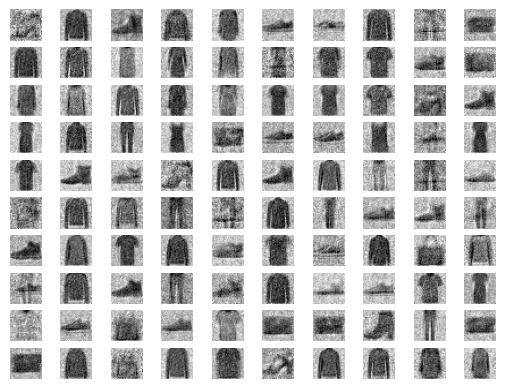

In [ ]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)


8. **Eğitilen Modeli Yükleme ve Görüntü Üretme**:

 - Eğitilen model yüklenir ve yeni sahte görüntüler üretmek için kullanılır. Üretilen görüntüler gösterilir ve kaydedilir.


In [ ]:
model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)


4/4 [==============================] - 0s 10ms/step


ValueError: Number of rows must be a positive integer, not 10.0

<Figure size 640x480 with 0 Axes>